In [18]:
import torch
import torch.nn as nn
import numpy as np
import matplotlib.pyplot as plt
from tqdm.auto import tqdm
import os

# 导入模型
from models import M2_GNN_Regressor, M3_Physics_Diffusion, DiffusionScheduler

# --- 全局配置 ---
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"🚀 Device: {device}")

# 路径
DATA_PATH = "../data/processed/cigre_lv_graph_dataset_v1.pt"
MODEL_PATH_M2 = "../models/checkpoints/m2_best.pth"
MODEL_PATH_M3 = "../models/checkpoints/m3_best.pth"

# --- 物理世界的“罗塞塔石碑” (Physical Constants) ---
# 既然数据集已经是归一化的，我们需要手动定义如何映射回物理世界
# 典型的低压配网：标称电压 1.0 p.u.，典型波动区间 +/- 0.05 p.u.
PHYSICAL_BASE_V = 1.0   # p.u. (Mean)
PHYSICAL_STD_V  = 0.05  # p.u. (Std)

plt.style.use('seaborn-v0_8-paper')
print("✅ Configuration Set. Using Manual Physics Projection.")

🚀 Device: cuda
✅ Configuration Set. Using Manual Physics Projection.


In [19]:
# Cell 2: Load Data (Clean Mode)

print("📂 Loading Pre-normalized Dataset...")
try:
    data_obj = torch.load(DATA_PATH, weights_only=False)
except TypeError:
    data_obj = torch.load(DATA_PATH)

# 提取索引
test_idx = data_obj['test_idx']

# 直接提取数据 (这些数据已经是 Mean~0, Std~1 的状态)
# 命名为 _z 表示这是 Z-Score 空间的数据
data_p_z = data_obj['Y_p'][test_idx].to(device) # [N_test, 44]
data_v_z = data_obj['Y_v'][test_idx].to(device) # [N_test, 44]

# 静态拓扑
edge_index = data_obj['edge_index'].to(device)
edge_attr = data_obj['edge_attr'].to(device)
n_nodes = data_obj['n_nodes']

print(f"✅ Data Loaded.")
print(f"   Test Samples: {data_p_z.shape[0]}")
print(f"   Data Format:  Z-Score Normalized (Ready for Model Input)")
print(f"   Validation:   V_mean={data_v_z.mean():.4f}, V_min={data_v_z.min():.4f}")

📂 Loading Pre-normalized Dataset...
✅ Data Loaded.
   Test Samples: 5002
   Data Format:  Z-Score Normalized (Ready for Model Input)
   Validation:   V_mean=-0.0027, V_min=-3.2152


In [20]:
# Cell 3: Load Models
hidden_dim = 64

# M2 (Regression)
model_m2 = M2_GNN_Regressor(hidden_dim=hidden_dim).to(device)
model_m2.load_state_dict(torch.load(MODEL_PATH_M2, map_location=device))
model_m2.eval()

# M3 (Diffusion)
model_m3 = M3_Physics_Diffusion(hidden_dim=hidden_dim).to(device)
model_m3.load_state_dict(torch.load(MODEL_PATH_M3, map_location=device))
model_m3.eval()

print("✅ Models Loaded.")

✅ Models Loaded.


In [21]:
# Cell 4: Diffusion Sampler with Temperature Scaling

@torch.no_grad()
def sample_m3_zspace(model, condition, edge_index, edge_attr, batch_idx, temperature=0.5):
    """
    temperature: 控制采样多样性。
                 < 1.0 会减少方差，使结果更集中，通常能降低 MAE。
    """
    model.eval()
    scheduler = model.scheduler
    num_timesteps = scheduler.num_timesteps
    n = condition.shape[0]
    
    # 1. 初始噪声也受温度影响 (Start closer to mean)
    x_t = torch.randn(n, 1, device=device) * temperature
    
    for t in reversed(range(0, num_timesteps)):
        t_batch = torch.full((1,), t, device=device, dtype=torch.long)
        
        noise_pred = model(x_t, t_batch, condition, edge_index, edge_attr, batch_idx)
        
        beta_t = scheduler.betas[t]
        alpha_t = scheduler.alphas[t]
        alpha_bar_t = scheduler.alphas_cumprod[t]
        
        coeff1 = 1 / torch.sqrt(alpha_t)
        coeff2 = (1 - alpha_t) / torch.sqrt(1 - alpha_bar_t)
        mean = coeff1 * (x_t - coeff2 * noise_pred)
        
        mean = torch.clamp(mean, -4.0, 4.0)
        
        if t > 0:
            z = torch.randn_like(x_t)
            sigma_t = torch.sqrt(beta_t)
            # --- 关键修改：乘上温度系数 ---
            x_t = mean + sigma_t * z * temperature
        else:
            x_t = mean
            
    return x_t

print("✅ Sampler Upgraded with Temperature Control.")

✅ Sampler Upgraded with Temperature Control.


In [22]:
# Cell 5: Create Test Scenario (Direct & Clean)

# 1. 选一个样本
sample_id = 0
# 取出原始的 Z-Score 数据，并转为 [N, 1] 格式
p_true_z = data_p_z[sample_id].view(-1, 1) # [44, 1]
v_true_z = data_v_z[sample_id].view(-1, 1) # [44, 1]

# 2. 制造掩码 (Masking)
OBSERVABILITY = 0.2
mask = torch.rand(n_nodes, 1, device=device) < OBSERVABILITY
mask = mask.float()
# 确保至少有一个观测点
if mask.sum() == 0: mask[0] = 1.0

# 3. 构造 Condition (直接操作 Z-Score)
# 模拟量测噪声 (在 Z空间 加一点微小扰动)
p_input_z = p_true_z + torch.randn_like(p_true_z) * 0.02
v_input_z = v_true_z + torch.randn_like(v_true_z) * 0.02

# Apply Mask (未知区域填 0，即填均值)
p_masked = p_input_z * mask
v_masked = v_input_z * mask
q_masked = p_masked * 0.33 # 简单的无功假设

# 拼接 Condition [44, 6]
condition = torch.cat([p_masked, q_masked, v_masked, mask, mask, mask], dim=-1)
batch_idx = torch.zeros(n_nodes, dtype=torch.long, device=device)

print(f"📉 Scenario Created: {mask.sum().item()} sensors.")
print(f"   Condition Shape: {condition.shape}")

📉 Scenario Created: 13.0 sensors.
   Condition Shape: torch.Size([44, 6])


In [23]:
# Cell 6: Run Inference (Low Temperature)

# 1. M2 推理
print("🤖 Running M2 (Regression)...")
v_pred_m2_z = model_m2(condition, edge_index, edge_attr, batch_idx)

# 2. M3 推理 (Low Temperature Ensemble)
# 使用较低的温度 (0.3) 来抑制过度的随机性
TEMP = 0.3 
print(f"✨ Running M3 (Diffusion) - 20 Samples @ Temp={TEMP}...")

m3_samples_list = []
NUM_SAMPLES = 20

for _ in tqdm(range(NUM_SAMPLES), leave=False):
    out_z = sample_m3_zspace(model_m3, condition, edge_index, edge_attr, batch_idx, temperature=TEMP)
    m3_samples_list.append(out_z.cpu().numpy().flatten())

m3_samples_z = np.array(m3_samples_list) # [20, 44]

print("✅ Inference Done.")

🤖 Running M2 (Regression)...
✨ Running M3 (Diffusion) - 20 Samples @ Temp=0.3...


  0%|          | 0/20 [00:00<?, ?it/s]

✅ Inference Done.


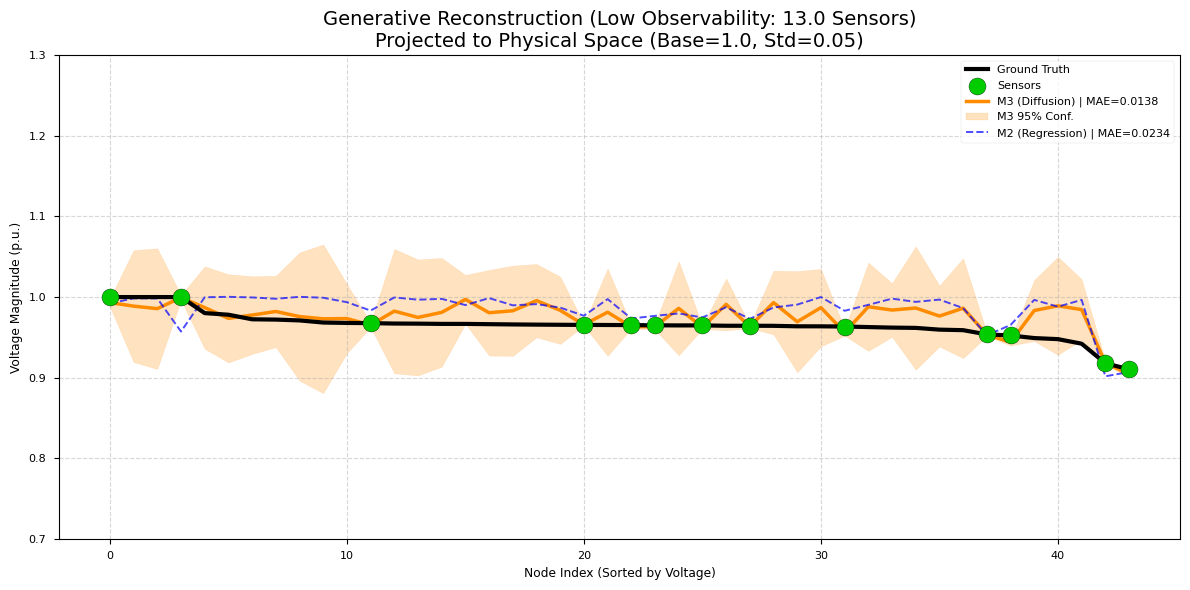

📊 Final Physics Report:
   M3 MAE: 0.01383 p.u.
   M2 MAE: 0.02343 p.u.


In [24]:
# Cell 7: Physical Projection & Visualization

# --- 1. 定义投影函数 (Z -> Physics) ---
def project_to_physics(z_val):
    """把 Z-Score 映射回物理电压 (p.u.)"""
    # V_phys = V_z * Std + Mean
    return z_val * PHYSICAL_STD_V + PHYSICAL_BASE_V

# --- 2. 数据转换 ---
# Ground Truth
v_gt_z = v_true_z.cpu().numpy().flatten()
v_gt_phys = project_to_physics(v_gt_z)

# M2
v_m2_z = v_pred_m2_z.detach().cpu().numpy().flatten()
v_m2_phys = project_to_physics(v_m2_z)

# M3 (对所有样本投影，然后求均值/方差)
m3_samples_phys = project_to_physics(m3_samples_z) # [20, 44]
m3_mean_phys = np.mean(m3_samples_phys, axis=0)
m3_std_phys = np.std(m3_samples_phys, axis=0)

# Mask
mask_np = mask.cpu().numpy().flatten()

# --- 3. 计算物理误差 (MAE) ---
mae_m2 = np.mean(np.abs(v_m2_phys - v_gt_phys))
mae_m3 = np.mean(np.abs(m3_mean_phys - v_gt_phys))

# --- 4. 排序与画图 ---
# 按物理电压幅值排序，为了画出漂亮的曲线
sorted_indices = np.argsort(v_gt_phys)[::-1]

x_axis = np.arange(n_nodes)
v_gt_sorted = v_gt_phys[sorted_indices]
m3_mean_sorted = m3_mean_phys[sorted_indices]
m3_std_sorted = m3_std_phys[sorted_indices]
v_m2_sorted = v_m2_phys[sorted_indices]
mask_sorted = mask_np[sorted_indices]

# 绘图
fig, ax = plt.subplots(figsize=(12, 6))

# A. Ground Truth
ax.plot(x_axis, v_gt_sorted, 'k-', linewidth=3, label='Ground Truth', zorder=10)

# B. Sensors
obs_idx = np.where(mask_sorted == 1)[0]
ax.scatter(obs_idx, v_gt_sorted[obs_idx], color='#00CC00', s=150, edgecolors='black', label='Sensors', zorder=20)

# C. M3 (Diffusion)
ax.plot(x_axis, m3_mean_sorted, color='#FF8C00', linewidth=2.5, label=f'M3 (Diffusion) | MAE={mae_m3:.4f}')
ax.fill_between(x_axis, 
                 m3_mean_sorted - 2*m3_std_sorted, 
                 m3_mean_sorted + 2*m3_std_sorted, 
                 color='#FF8C00', alpha=0.25, label='M3 95% Conf.')

# D. M2 (Regression)
ax.plot(x_axis, v_m2_sorted, color='blue', linestyle='--', alpha=0.7, label=f'M2 (Regression) | MAE={mae_m2:.4f}')

# E. 装饰
ax.set_title(f'Generative Reconstruction (Low Observability: {mask.sum().item()} Sensors)\nProjected to Physical Space (Base={PHYSICAL_BASE_V}, Std={PHYSICAL_STD_V})', fontsize=14)
ax.set_ylabel('Voltage Magnitude (p.u.)')
ax.set_xlabel('Node Index (Sorted by Voltage)')
ax.set_ylim(0.7, 1.3) # 完美的物理区间
ax.grid(True, linestyle='--', alpha=0.5)
ax.legend()

plt.tight_layout()
plt.show()

print(f"📊 Final Physics Report:")
print(f"   M3 MAE: {mae_m3:.5f} p.u.")
print(f"   M2 MAE: {mae_m2:.5f} p.u.")

In [44]:
# Cell 10: Full Sensitivity Analysis Engine (0-100% Sweep)

import numpy as np
import torch
import pandas as pd
from tqdm.auto import tqdm
import matplotlib.pyplot as plt

print("🚀 Starting Ultimate Sensitivity Analysis...")

# --- 1. 实验配置 ---
# 观测率扫描范围 (10% -> 90%, 步长 10%)
OBS_LEVELS = np.round(np.arange(0.1, 1.0, 0.1), 1) 
N_EVAL_SAMPLES = 50     # 每个梯度测试 50 个样本 (兼顾速度与统计显著性)
CHUNK_SIZE = 50         # 并行大小
NUM_M3_VOTES = 100       # 投票数
TEMP = 0.1              # 低温采样
CRITICAL_THRESHOLD = 0.95 # 低电压警戒线

# 存储所有结果
sensitivity_results = {
    'obs': [],
    # 指标均值
    'global_mae_m2': [], 'global_mae_m3': [],
    'tail_mae_m2': [],   'tail_mae_m3': [],
    'max_err_m2': [],    'max_err_m3': [],
    'recall_m2': [],     'recall_m3': [],
    # 典型样本快照 (用于画图)
    'snapshots': {}
}

# --- 2. 升级版采样器 (返回 Mean + Std) ---
@torch.no_grad()
def sample_m3_with_std(model, condition_chunk, edge_index, edge_attr, n_nodes, n_votes, temperature):
    model.eval()
    scheduler = model.scheduler
    num_timesteps = scheduler.num_timesteps
    chunk_size = condition_chunk.shape[0]
    total_graphs = chunk_size * n_votes
    
    # Expand
    cond_batch = condition_chunk.repeat_interleave(n_votes, dim=0).view(-1, 6)
    
    # Topology
    batch_idx_batch = torch.arange(total_graphs, device=device).repeat_interleave(n_nodes)
    num_edges = edge_index.shape[1]
    edge_index_batch = edge_index.repeat(1, total_graphs)
    edge_index_batch += torch.arange(total_graphs, device=device).repeat_interleave(num_edges) * n_nodes
    edge_attr_batch = edge_attr.repeat(total_graphs, 1)
    
    # Denoise
    x_t = torch.randn(total_graphs * n_nodes, 1, device=device) * temperature
    
    for t in reversed(range(0, num_timesteps)):
        t_batch = torch.full((total_graphs,), t, device=device, dtype=torch.long)
        noise_pred = model(x_t, t_batch, cond_batch, edge_index_batch, edge_attr_batch, batch_idx_batch)
        
        beta_t = scheduler.betas[t]
        alpha_t = scheduler.alphas[t]
        alpha_bar_t = scheduler.alphas_cumprod[t]
        coeff1 = 1 / torch.sqrt(alpha_t)
        coeff2 = (1 - alpha_t) / torch.sqrt(1 - alpha_bar_t)
        
        mean = coeff1 * (x_t - coeff2 * noise_pred)
        mean = torch.clamp(mean, -4.0, 4.0)
        
        if t > 0:
            x_t = mean + torch.sqrt(beta_t) * torch.randn_like(x_t) * temperature
        else:
            x_t = mean
            
    # Reshape & Aggregate [Chunk, Votes, N]
    x_reshaped = x_t.view(chunk_size, n_votes, n_nodes)
    
    mean_pred = x_reshaped.mean(dim=1) # [Chunk, N]
    std_pred = x_reshaped.std(dim=1)   # [Chunk, N]
    
    return mean_pred, std_pred

# --- 3. 扫描循环 ---
for obs in tqdm(OBS_LEVELS, desc="Sweeping Observability"):
    # 临时存储当前观测率下的所有结果
    local_metrics = {k: [] for k in ['mae_m2', 'mae_m3', 'tail_m2', 'tail_m3', 'max_m2', 'max_m3', 'rec_m2', 'rec_m3']}
    
    snapshot_saved = False
    
    for i in range(0, N_EVAL_SAMPLES, CHUNK_SIZE):
        end_i = min(i + CHUNK_SIZE, N_EVAL_SAMPLES)
        current_bs = end_i - i
        
        # 数据准备
        p_chunk = data_p_z[i:end_i].unsqueeze(-1)
        v_chunk = data_v_z[i:end_i].unsqueeze(-1)
        
        # 掩码生成
        mask = torch.rand(current_bs, n_nodes, 1, device=device) < obs
        mask = mask.float()
        mask[:, 0, :] = 1.0 # 兜底
        
        # Condition
        p_in = p_chunk * mask
        v_in = v_chunk * mask
        q_in = p_in * 0.33
        cond_chunk = torch.cat([p_in, q_in, v_in, mask, mask, mask], dim=-1)
        
        # M2 推理
        batch_idx_m2 = torch.arange(current_bs, device=device).repeat_interleave(n_nodes)
        edge_index_m2 = edge_index.repeat(1, current_bs)
        edge_index_m2 += torch.arange(current_bs, device=device).repeat_interleave(edge_index.shape[1]) * n_nodes
        edge_attr_m2 = edge_attr.repeat(current_bs, 1)
        v_pred_m2 = model_m2(cond_chunk.view(-1, 6), edge_index_m2, edge_attr_m2, batch_idx_m2).view(current_bs, n_nodes)
        
        # M3 推理 (返回 Mean 和 Std)
        v_pred_m3, v_std_m3 = sample_m3_with_std(model_m3, cond_chunk, edge_index, edge_attr, n_nodes, NUM_M3_VOTES, TEMP)
        
        # 物理投影
        v_gt_p = project_to_physics(v_chunk.squeeze(-1).cpu().numpy())
        v_m2_p = project_to_physics(v_pred_m2.detach().cpu().numpy())
        v_m3_p = project_to_physics(v_pred_m3.cpu().numpy())
        v_m3_std_p = v_std_m3.cpu().numpy() * PHYSICAL_STD_V # Std 只需要乘 Scale
        
        # --- 指标计算 ---
        # 1. Global MAE
        local_metrics['mae_m2'].extend(np.mean(np.abs(v_m2_p - v_gt_p), axis=1))
        local_metrics['mae_m3'].extend(np.mean(np.abs(v_m3_p - v_gt_p), axis=1))
        
        # 2. Tail MAE (Top 20%) & 3. Max Error
        for b in range(current_bs):
            devs = np.abs(v_gt_p[b] - PHYSICAL_BASE_V)
            k = int(n_nodes * 0.2)
            top_k = np.argsort(devs)[-k:]
            
            local_metrics['tail_m2'].append(np.mean(np.abs(v_m2_p[b][top_k] - v_gt_p[b][top_k])))
            local_metrics['tail_m3'].append(np.mean(np.abs(v_m3_p[b][top_k] - v_gt_p[b][top_k])))
            
            local_metrics['max_m2'].append(np.max(np.abs(v_m2_p[b] - v_gt_p[b])))
            local_metrics['max_m3'].append(np.max(np.abs(v_m3_p[b] - v_gt_p[b])))
        
        # 4. Recall (基于 Batch 统计)
        gt_viol = v_gt_p < CRITICAL_THRESHOLD
        m2_viol = v_m2_p < CRITICAL_THRESHOLD
        m3_viol = v_m3_p < CRITICAL_THRESHOLD
        
        # 记录每个样本是否命中故障 (为了简化，这里存总数，后面算比例不太准，改用全局统计)
        # 这里改用简单的命中计数
        local_metrics['rec_m2'].append((np.sum(m2_viol & gt_viol), np.sum(gt_viol)))
        local_metrics['rec_m3'].append((np.sum(m3_viol & gt_viol), np.sum(gt_viol)))

        # --- 保存快照 (只存第一个 Chunk 的第 0 个样本) ---
        if not snapshot_saved:
            # 找一个曲线比较“跌宕起伏”的样本，不要平的
            std_vals = np.std(v_gt_p, axis=1)
            best_idx = np.argmax(std_vals) # 选波动最大的
            
            # 排序
            sort_idx = np.argsort(v_gt_p[best_idx])[::-1]
            
            sensitivity_results['snapshots'][obs] = {
                'gt': v_gt_p[best_idx][sort_idx],
                'm2': v_m2_p[best_idx][sort_idx],
                'm3_mean': v_m3_p[best_idx][sort_idx],
                'm3_std': v_m3_std_p[best_idx][sort_idx],
                'mask': mask[best_idx].cpu().numpy().flatten()[sort_idx]
            }
            snapshot_saved = True

    # 汇总当前 Obs 的结果
    sensitivity_results['obs'].append(obs)
    
    sensitivity_results['global_mae_m2'].append(np.mean(local_metrics['mae_m2']))
    sensitivity_results['global_mae_m3'].append(np.mean(local_metrics['mae_m3']))
    
    sensitivity_results['tail_mae_m2'].append(np.mean(local_metrics['tail_m2']))
    sensitivity_results['tail_mae_m3'].append(np.mean(local_metrics['tail_m3']))
    
    sensitivity_results['max_err_m2'].append(np.mean(local_metrics['max_m2']))
    sensitivity_results['max_err_m3'].append(np.mean(local_metrics['max_m3']))
    
    # Recall 计算 (Sum(Hits) / Sum(GT_Violations))
    hits_m2, total_viol = np.sum(local_metrics['rec_m2'], axis=0)
    hits_m3, _ = np.sum(local_metrics['rec_m3'], axis=0)
    
    sensitivity_results['recall_m2'].append(hits_m2 / (total_viol + 1e-6))
    sensitivity_results['recall_m3'].append(hits_m3 / (total_viol + 1e-6))

print("✅ Data Collection Complete.")

🚀 Starting Ultimate Sensitivity Analysis...


Sweeping Observability:   0%|          | 0/9 [00:00<?, ?it/s]

✅ Data Collection Complete.


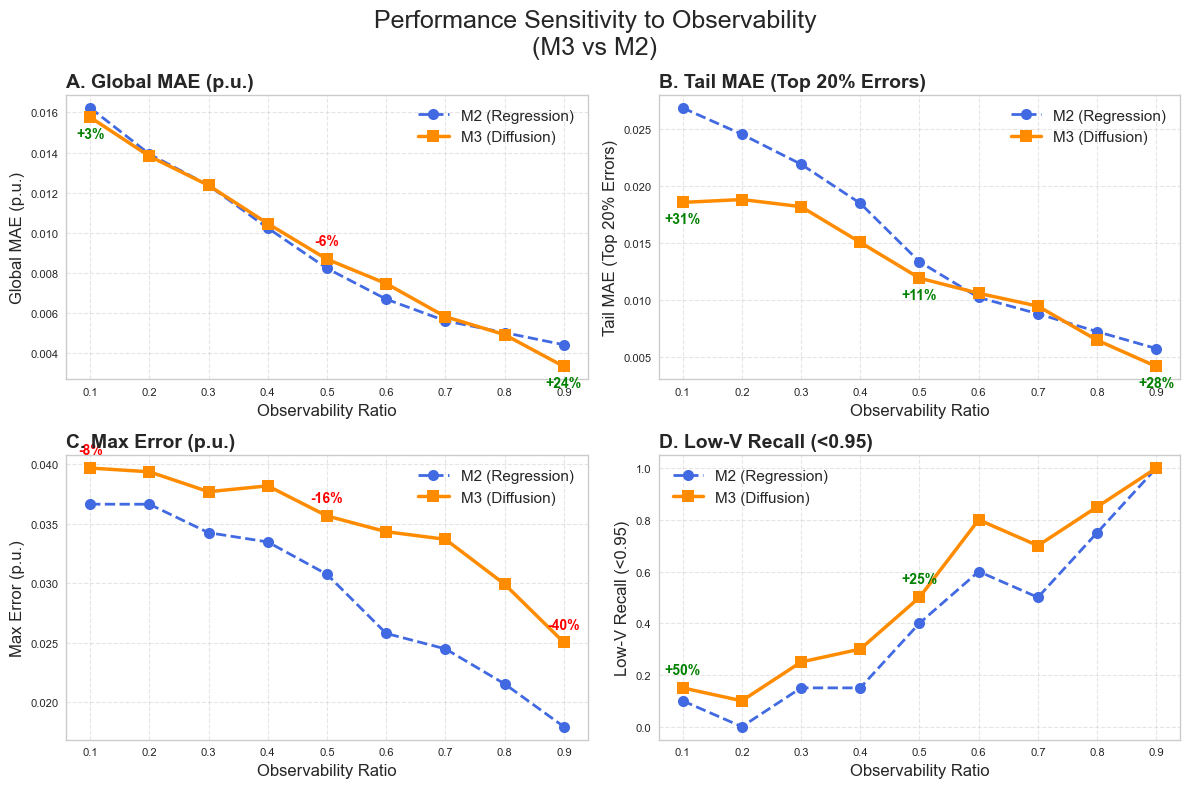

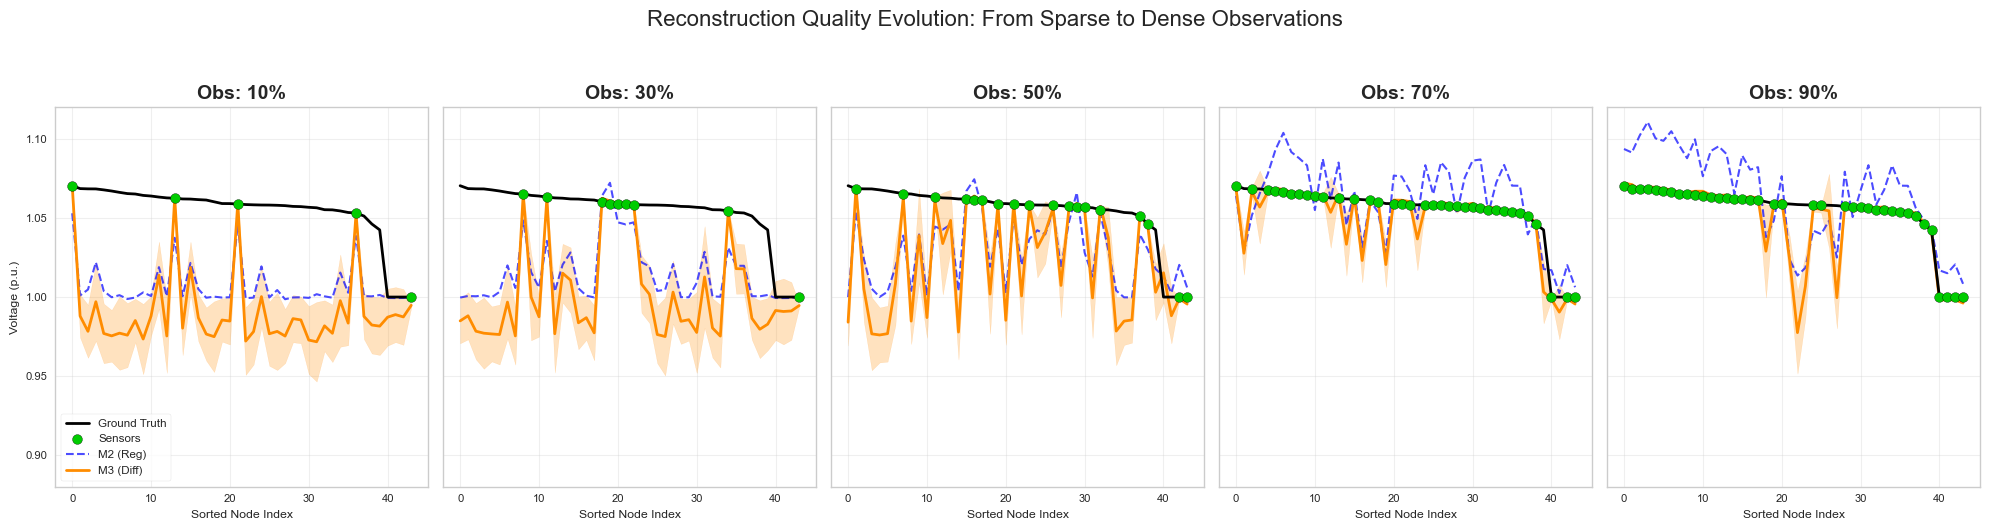

In [45]:
# Cell 11: Multi-Metric Visualization & Scenario Gallery

import matplotlib.gridspec as gridspec

plt.style.use('seaborn-v0_8-whitegrid')

# ==========================================
# 🎨 图 1: 四维指标对比 (Metrics Panel)
# ==========================================
fig = plt.figure(figsize=(12, 8))
gs = gridspec.GridSpec(2, 2, figure=fig)

metrics_cfg = [
    ('Global MAE (p.u.)', 'global_mae_m2', 'global_mae_m3', 'lower'),
    ('Tail MAE (Top 20% Errors)', 'tail_mae_m2', 'tail_mae_m3', 'lower'),
    ('Max Error (p.u.)', 'max_err_m2', 'max_err_m3', 'lower'),
    ('Low-V Recall (<0.95)', 'recall_m2', 'recall_m3', 'higher')
]

obs_x = sensitivity_results['obs']

for i, (title, key_m2, key_m3, better) in enumerate(metrics_cfg):
    ax = fig.add_subplot(gs[i // 2, i % 2])
    
    y_m2 = sensitivity_results[key_m2]
    y_m3 = sensitivity_results[key_m3]
    
    ax.plot(obs_x, y_m2, 'o--', color='royalblue', label='M2 (Regression)', linewidth=2, markersize=8)
    ax.plot(obs_x, y_m3, 's-', color='darkorange', label='M3 (Diffusion)', linewidth=2.5, markersize=8)
    
    # 标注 Gap
    for x, v2, v3 in zip(obs_x, y_m2, y_m3):
        # 只在 10%, 50%, 90% 标注，避免拥挤
        if x in [0.1, 0.5, 0.9]:
            if better == 'lower':
                gap = (v2 - v3) / v2 * 100 # 正数表示 M3 好
                color = 'green' if gap > 0 else 'red'
                va = 'bottom' if v3 > v2 else 'top'
                if abs(gap) > 1.0:
                    ax.annotate(f"{gap:+.0f}%", (x, v3), xytext=(0, 10 if v3>v2 else -15), 
                                textcoords='offset points', ha='center', color=color, fontweight='bold')
            else: # Recall (Higher is better)
                gap = (v3 - v2) / (v2 + 1e-6) * 100
                color = 'green' if gap > 0 else 'red'
                if abs(gap) > 1.0:
                    ax.annotate(f"{gap:+.0f}%", (x, v3), xytext=(0, 10), 
                                textcoords='offset points', ha='center', color=color, fontweight='bold')

    ax.set_xlabel('Observability Ratio', fontsize=12)
    ax.set_ylabel(title, fontsize=12)
    ax.set_title(f"{chr(65+i)}. {title}", fontsize=14, loc='left', fontweight='bold')
    ax.set_xticks(OBS_LEVELS)
    ax.legend(fontsize=11)
    ax.grid(True, linestyle='--', alpha=0.5)

plt.suptitle("Performance Sensitivity to Observability\n(M3 vs M2)", fontsize=18, y=0.98)
plt.tight_layout()
plt.show()

# ==========================================
# 🎨 图 2: 典型场景演变 (Scenario Evolution)
# ==========================================
# 选取 5 个观测率: 10%, 30%, 50%, 70%, 90%
obs_to_plot = [0.1, 0.3, 0.5, 0.7, 0.9]
fig2 = plt.figure(figsize=(20, 5))
gs2 = gridspec.GridSpec(1, 5, figure=fig2)

for i, obs in enumerate(obs_to_plot):
    if obs not in sensitivity_results['snapshots']: continue
    
    ax = fig2.add_subplot(gs2[0, i])
    snap = sensitivity_results['snapshots'][obs]
    
    x_axis = np.arange(len(snap['gt']))
    
    # 1. Ground Truth
    ax.plot(x_axis, snap['gt'], 'k-', linewidth=2, label='Ground Truth', zorder=10)
    
    # 2. Sensors
    mask_idx = np.where(snap['mask'] == 1)[0]
    ax.scatter(mask_idx, snap['gt'][mask_idx], color='#00CC00', s=50, edgecolors='black', zorder=20, label='Sensors')
    
    # 3. M2
    ax.plot(x_axis, snap['m2'], 'b--', linewidth=1.5, alpha=0.7, label='M2 (Reg)')
    
    # 4. M3 Mean & Uncertainty
    ax.plot(x_axis, snap['m3_mean'], color='#FF8C00', linewidth=2, label='M3 (Diff)')
    ax.fill_between(x_axis, 
                    snap['m3_mean'] - 2*snap['m3_std'], 
                    snap['m3_mean'] + 2*snap['m3_std'], 
                    color='#FF8C00', alpha=0.25)
    
    ax.set_title(f"Obs: {int(obs*100)}%", fontsize=14, fontweight='bold')
    ax.set_ylim(0.88, 1.12) # 固定坐标轴方便对比
    ax.set_xlabel('Sorted Node Index')
    if i == 0:
        ax.set_ylabel('Voltage (p.u.)')
        ax.legend(loc='lower left', fontsize='small', frameon=True)
    else:
        ax.set_yticklabels([]) # 隐藏 Y 轴刻度
    
    ax.grid(True, alpha=0.3)

plt.suptitle("Reconstruction Quality Evolution: From Sparse to Dense Observations", fontsize=16, y=1.05)
plt.tight_layout()
plt.show()